# BDT Performance Validation Plots for $H \rightarrow \rho\gamma, \phi\gamma$ Analysis

In [173]:
# Handling ROOT files
import os, sys, json
import numpy as np, pandas as pd
import uproot, pickle
# Plotting
import matplotlib
from matplottery import Hist1D, Hist2D, plot_stack
import matplotlib.pyplot as plt
# Machine Learning
from sklearn.metrics import roc_curve
import xgboost as xgb # BDT
# Custom Tools
from tools import GetData
from config import config
# Jupyter Display Settings
%matplotlib inline
pd.set_option('display.max_rows', 20)

## Get Test Data and BDT Model

In [174]:
# Get testing dataset
x_test = pd.read_pickle("x_test.pkl", compression="gzip")
# Get BDT model
bst = pickle.load(open("bdt.pkl", "r"))
# Get BDT features
with open("features.json", "r") as fin:
    features = json.load(fin)

## Define BDT and Cut-based Analysis Methods

In [176]:
# Get BDT predictions
preds = bst.predict(xgb.DMatrix(x_test[features]))
# Define cuts
higgsMassCut = ((x_test.recoHiggs_mass > 0) & (x_test.recoHiggs_mass < 1000))
phiMassCut = ((x_test.recoPhi_mass > 1.0) & (x_test.recoPhi_mass < 1.04))
dRCut = (x_test.recoKpKm_dR < 0.015)
ptCut = ((x_test.recoPhi_pt > 25) & (x_test.recoGamma_pt > 30)) # Re-weighted by Higgs mass
isoCut = (x_test.recoPhi_relIso < 0.01)
# Cut-based
cutBased = x_test[higgsMassCut & phiMassCut & dRCut & ptCut & isoCut]
# BDT
bdtBased = x_test[higgsMassCut & (preds > 0.9)]

## Plot Performance

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in divide
  del sys.path[0]


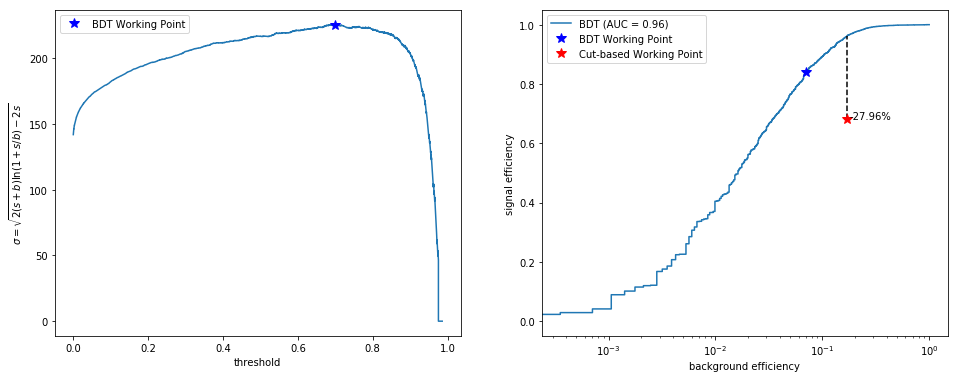

In [177]:
# Subplots setup
fig, axes = plt.subplots(1,2,figsize=(16,6))
# BDT ROC Curve
fpr, tpr, thresh = roc_curve(x_test[higgsMassCut]["signal"], preds[higgsMassCut])

# BDT Working Point vs. Efficiency
plt.subplot(1,2,1)
# Signal, background counts
counts = x_test.signal.value_counts()
nSig = tpr*counts[True]
nBg = fpr*counts[False]
# Sigma
sigma = (2*(nSig+nBg)*np.log(1+nSig/nBg)-2*nSig)**0.5
sigma[~np.isfinite(sigma)] = 0.0
# Optimal points
bestEff = max(sigma)
bestBDT = thresh[np.where(sigma == bestEff)[0][0]]
# Plot
plt.plot(thresh, sigma)
plt.plot(bestBDT, bestEff, "b*", label="BDT Working Point", markersize=10);
# Settings
plt.xlabel("threshold");
plt.ylabel("$\sigma = \sqrt{2(s+b)\ln(1+s/b)-2s}$");
plt.legend();

# BDT & Cut-based working points
plt.subplot(1,2,2)
# BDT-based
bdtPoint = np.where(thresh > bestBDT)[0][-1]
predFPR = fpr[bdtPoint]
predTPR = tpr[bdtPoint]
# Cut-based
cutsFPR = 1.0*len(cutBased[cutBased.signal == 0])/len(x_test[(x_test.signal == 0) & higgsMassCut])
cutsTPR = 1.0*len(cutBased[cutBased.signal == 1])/len(x_test[(x_test.signal == 1) & higgsMassCut])
cutsTPR_onROC = tpr[np.where(fpr < cutsFPR)[0][-1]]
# Plot
bins = np.linspace(0.,1.,30)
plt.semilogx(fpr, tpr, label="BDT (AUC = {:.2f})".format(np.trapz(tpr,fpr)));
plt.plot([cutsFPR, cutsFPR], [cutsTPR, cutsTPR_onROC], 'k--')
plt.plot(predFPR, predTPR, "b*", label="BDT Working Point", markersize=10);
plt.plot(cutsFPR, cutsTPR, "r*", label="Cut-based Working Point", markersize=10);
plt.text(cutsFPR+0.01, cutsTPR, "{:.2f}%".format((cutsTPR-cutsTPR_onROC)*100), fontsize=10)
# Settings
plt.xlabel("background efficiency");
plt.ylabel("signal efficiency");
plt.legend();